### 数据加载

在pytorch中，数据加载通常通过继承抽象类`Dataset`实现，并实现两个python自定义方法：
1. `__getitem__`方法
2. `__len__`方法


In [1]:
import os
from PIL import Image
import numpy as np
import torch as t
from torch.utils import data

class DogCat(data.Dataset):
    def __init__(self, root):
        imgs = os.listdir(root)
        # 保存绝对路径
        self.imgs = [os.path.join(root,img) for img in imgs]
    def __getitem__(self, index):
        img_path = self.imgs[index]
        label = 1 if 'dog' in img_path.split('/')[-1] else 0
        pil_img = Image.open(img_path)
        array = np.asarray(pil_img)
        data = t.from_numpy(array)
        return data, label
    def __len__(self):
        return len(self.imgs)

在`./data/dogcat/`目录下面有4张dog和4张cat图片，我们利用我们自定义的实现类`DogCat`来尝试加载这批数据

In [2]:
dataset = DogCat('./data/dogcat/')
img, label = dataset[0]
for img, label in dataset:
    print(img.size(), img.float().mean(), label)

torch.Size([374, 500, 3]) tensor(119.7826) 0
torch.Size([280, 300, 3]) tensor(71.6653) 0
torch.Size([396, 312, 3]) tensor(131.8400) 0
torch.Size([414, 500, 3]) tensor(156.6921) 0
torch.Size([375, 499, 3]) tensor(96.8243) 0
torch.Size([375, 499, 3]) tensor(116.7904) 1
torch.Size([499, 327, 3]) tensor(133.5602) 1
torch.Size([199, 187, 3]) tensor(143.0630) 1
torch.Size([375, 499, 3]) tensor(129.4572) 1
torch.Size([287, 300, 3]) tensor(117.9481) 1


从上面的输出结果可以看到，每个图片大小不一致，返回样本的数值较大，为归一化至[-1,1]，因此需要在获取数据的时候进行一些预处理，pytorch提供了`torchvision`，专门用于处理图片，其中`transfroms`模块提供了对`PIL`的`Image`和`pytorch`的`Tensor`的常用操作：

对`PIL`的常用操作有：
1. Resieze，调整图片尺寸
2. CenterCrop、RandomCrop、RandomSizedCrop，裁剪图片
3. Pad，填充
4. Lambda，接受一个函数，该函数接受一个Image参数
4. ToTensor，将PIL的Image对象专为Tensor，会自动将[0,255]归一化至[-1,1]

对Tensor的常用操作有：
1. Normalize，标准化，即减均值，除以标准差
2. ToPILImage，将Tensor转为PIL的Image对象

如果要对多张图片操作，类似于第8节的多模块，可以通过transform模块下的**Compose**将我们对图片的操作拼接起来，类似于`nn.Sequential`，Compose实现了python的魔法函数`__call__`，因此可直接调用。

In [ ]:
import os
from PIL import Image
import numpy as np
import torch as t
from torch.utils import data
from torchvision import transforms as T

transform = T.Compose([T.Resize(224),  # 保持长宽比不变，最短边为224像素
                      T.CenterCrop(224), # 从图片中间切出224像素
                      T.ToTensor(), 
                      T.Normalize(mean=[.5,.5,.5], std=[.5,.5,.5])])
class DogCat(data.Dataset):
    def __init__(self, root, transform = None):
        imgs = os.listdir(root)
        # 保存绝对路径
        self.imgs = [os.path.join(root,img) for img in imgs]
        self.transform = transform
    def __getitem__(self, index):
        img_path = self.imgs[index]
        label = 1 if 'dog' in img_path.split('/')[-1] else 0
        data = Image.open(img_path)
        
        if self.transform:
            data = self.transform(data)
        return data, label
    def __len__(self):
        return len(self.imgs)

In [15]:
dataset = DogCat('./data/dogcat/')
img, label = dataset[0]
for img, label in dataset:
    print(img.size(), label)

torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 1


### pytorch内置数据集

torchvision已经内置了常用的DataSet，可通过`torchvision.datasets`来获取相应的数据集。具体数据情况参考[https://pytorch.org/docs/stable/torchvision/datasets.html](https://pytorch.org/docs/stable/torchvision/datasets.html)

In [ ]:
# from torchvision import datasets
# datasets.FashionMNIST('./data', train=False, download=True)

  2%|▏         | 532480/26421880 [00:13<19:17, 22359.47it/s]

#### ImageFolder

torchvision提供了一个常用工具类`ImageFolder`，功能和第一小节的`DogCat`功能类似，ImageFolder假设所有的文件按文件夹保存，**每个文件夹下存储同一个类别的图片**，文件夹名为类名。  
``` python
torchvision.datasets.ImageFolder(root, transform=None, target_transform=None, loader=<function default_loader>,is_valid_file=None)
```
它主要有以下四个参数：
1. root，在root指定路径下寻找图片
2. transform，对PIL Image进行转换操作
3. target_transform，对label的转换
4. loader，指定加载图片的函数，默认操作为读取为PIL Image对象

In [5]:
from torchvision.datasets import ImageFolder
dataset = ImageFolder('./data/dogcat2')
dataset.class_to_idx

{'cat': 0, 'dog': 1}

In [6]:
dataset.imgs

[('./data/dogcat2\\cat\\cat.1.jpg', 0),
 ('./data/dogcat2\\cat\\cat.2.jpg', 0),
 ('./data/dogcat2\\cat\\cat.3.jpg', 0),
 ('./data/dogcat2\\cat\\cat.4.jpg', 0),
 ('./data/dogcat2\\dog\\dog.0.jpg', 1),
 ('./data/dogcat2\\dog\\dog.1.jpg', 1),
 ('./data/dogcat2\\dog\\dog.2.jpg', 1),
 ('./data/dogcat2\\dog\\dog.3.jpg', 1),
 ('./data/dogcat2\\dog\\dog.4.jpg', 1)]

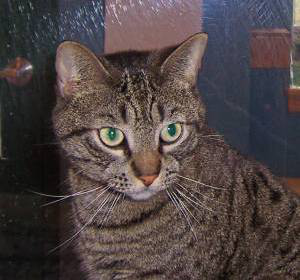

In [7]:
dataset[0][1] #第一维返回是第几张图片，第二维维1返回label
dataset[0][0] #第一维返回是第几张图片，第二维维0返回Image对象

In [8]:
# 加上transform
import os
from PIL import Image
import numpy as np
import torch as t
from torch.utils import data
from torchvision import transforms as T

transform = T.Compose([T.RandomResizedCrop(224),
                      T.RandomHorizontalFlip(),
                      T.ToTensor(),
                      T.Normalize(mean=[.4,.4,.4], std=[.2,.2,.2])])
dataset = ImageFolder('./data/dogcat2', transform=transform)
# 深度学习中，图片数据一般保存为CxHxW，即通道数x图片高x图片宽
dataset[0][0].size()

torch.Size([3, 224, 224])

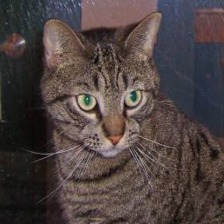

In [9]:
to_img = T.ToPILImage()
to_img(dataset[0][0]*.2+.4)

### 数据批量加载

前面我们介绍的DataSet只负责数据抽象，每次只返回一个样本，但是在训练神经网络的时候，我们是对一个batch的数据进行处理，同时还要进行shuffle和并行加速等， 因此pytorch提供了`DataLoader`来帮助我们实现这些功能
```
torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0, collate_fn=<function default_collate>, pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None)
```
1. dataset，加载的数据集，DataSet对象
2. batch_size，批大小
3. shuffle，是否将数据打乱
4. sample， 样本抽样
5. num_workers，使用多进程加速，0代表不加速
6. collate_fn，如何将多个样本数据拼接成一个batch，一般默认即可
7. pin_memory，是否将数据保存在pin memory区域，pip memoery区域的数据转到GPU会快些
8. drop_last, dataset中是护具可能不是batch_size的整数倍，drop_last为True时，会将多出来不足一个batch的数据丢去

In [10]:
import torch as t
from torch.utils.data import DataLoader

且DataLoader是一个可迭代对象，可以使用python的iter和next来操作。  
或者可直接通过for循环操作

In [11]:
dataloader = DataLoader(dataset, batch_size=3, shuffle=True, num_workers=0, drop_last=False)
dataiter = iter(dataloader)
imgs, labels = next(dataiter)
imgs.size()

torch.Size([3, 3, 224, 224])

### 异常数据处理

在数据处理中，经常有些图片损坏，这时，在`__getitem__`函数中将出现异常，此时最好的办法就是讲出错的样本剔除。也可以返回None对象，然后在DataLoader中自定义`collate_fn`，将空对象过滤掉，但是，在这种情况下，dataloader返回的一个batch的样本数量会少于指定的batch_size

In [30]:
class DogCat2(DogCat):
    def __getitem__(self, index):
        try:
            # 只有python3.x中允许直接调用super()
            # 由于python允许多继承，一般还是用super(Type, this)
            return super().__getitem__(index)
        except:
            return None,None
        
from torch.utils.data.dataloader import default_collate
def my_collate_fn(batch):
    '''
    batch中每个元素形如（data,label）
    '''
    batch = list(filter(lambda x:x[0] is not None, batch))
    return default_collate(batch)

In [31]:
dataset = DogCat2('./data/dogcat-wrong/')

In [32]:
dataloader = DataLoader(dataset, batch_size=3, shuffle=True, num_workers=0, collate_fn=my_collate_fn)
for batch_datas, batch_labels in dataloader:
    print(batch_datas.size(), batch_labels.size())

torch.Size([3, 3, 224, 224]) torch.Size([3])
torch.Size([3, 3, 224, 224]) torch.Size([3])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([1, 3, 224, 224]) torch.Size([1])


从上面结果可以看到，我们指定的batch_size是3，可是后两批数据已经不是3个元素了，这是因为我们中间有图片损坏，导致的。这种情况下：
1. 可以通过设置`drop_last=True`来丢弃最后一个样本数目不足batch_size的batch
2. 对于数据集损坏情况，可以随机取一张图片代替。

In [36]:
import random
class DogCat3(DogCat):
    def __getitem__(self, index):
        try:
            # 只有python3.x中允许直接调用super()
            # 由于python允许多继承，一般还是用super(Type, this)
            return super().__getitem__(index)
        except:
            new_index = random.randint(0, len(self)-1)
            return self[new_index]

dataset = DogCat3('./data/dogcat-wrong/')
dataloader = DataLoader(dataset, batch_size=3, shuffle=True, num_workers=0, collate_fn=my_collate_fn, drop_last=True)
for batch_datas, batch_labels in dataloader:
    print(batch_datas.size(), batch_labels.size())

torch.Size([3, 3, 224, 224]) torch.Size([3])
torch.Size([3, 3, 224, 224]) torch.Size([3])
torch.Size([3, 3, 224, 224]) torch.Size([3])


### 多进程加载数据

`DataLoader`封装了python的multiprocessing标准库，使其可以进行**多进程加速**。因此：
1. 高负载的操作尽量放在`__getitem__`中，比如加载图片
2. 由于是多进程操作，因此要尽量避免修改可变对象。比如：

In [37]:
class BadDataset(data.Dataset):
    def __init__(self):
        super().__init__()
        self.datas = range(100)
        self.num = 0
    def __getitem__(self, index):
        self.num += 1 # 这里就涉及到了可变对象的修改，如果一定要这样做，就不要使用多进程加速。
        return self.data[index]

### 数据重采样

1. pytorch提供了sampler模块，用于数据重采样。常用的随机采样器有`RandomSampler`，当dataloader的shuffle设置为True时，pytorch会默认调用这个采样器，打乱数据。  
2. 默认的采样器为`SequentialSampler`，他会按照顺序一个一个采样。  
3. 另外，pytorch提供了`WeightRandomSampler`采样器，他会根据每个样本的权重数据，在样本比例不均衡的情况下，可用它进行重采样。

In [ ]:
dataset = DogCat('./data/dogcat')